<a href="https://colab.research.google.com/github/firoozye/ATC_Notebooks/blob/main/IntradayForexData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One Minute EURUSD forecasts and strategy

## Using Free one Minute data

* (zipped) and on the https://www.histdata.com  webssite
* From Ninja Trader and other websites
* One minute HLOC for several years as needed
* We will only use 2023, already 300k rows of data
* Unfortunately the zip files must be manually downloaded (if free) but can be downloaded using sftp if a paid subscription
* I have uploaded some files to my Google drive

In [ ]:
import requests
import pandas as pd
import zipfile
import io
import os
from datetime import datetime
from typing import Optional, Tuple
import time
from urllib.parse import urljoin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Set the path to your data directory
BASE_PATH = '/content/drive/MyDrive/Algo_Trading_Class/FreeForexBars'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!cp -r /content/drive/MyDrive/Algo_Trading_Class/colab_files/ewrls /content/
!cp -r /content/drive/MyDrive/Algo_Trading_Class/colab_files/performance /content/
# copy from Drive to Colab to import

In [ ]:
import ewrls
import performance



# Download Data

Download free 1min bar data.


In [ ]:
import pandas as pd
import zipfile

def load_eurusd_data(base_path: str, year: int) -> pd.DataFrame:
    """
    Unzips the specified EURUSD data file and loads it into a pandas DataFrame.

    Args:
        base_path: The path to the directory containing the data file.
        year: The year of the data to load.

    Returns:
        A pandas DataFrame containing the EURUSD data.
    """
    file_path = os.path.join(base_path, f"HISTDATA_COM_NT_EURUSD_M1{year}.zip")
    with zipfile.ZipFile(file_path, "r") as zip_ref:
        zip_ref.extractall(base_path)

    csv_file_path = os.path.join(base_path, f"DAT_NT_EURUSD_M1_{year}.csv")
    df = pd.read_csv(
        csv_file_path,
        delimiter=";",
        names=["DateTime", "Open", "High", "Low", "Close", "Volume"],
        index_col=False,
    )
    df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y%m%d %H%M%S")
    df.set_index("DateTime", inplace=True)
    df = df[["Open", "High", "Low", "Close"]]
    df = df.rename(columns={col: f"EURUSD_{col}" for col in df.columns})
    return df

# Load the data for 2023
EURUSD = load_eurusd_data(BASE_PATH, 2023)
EURUSD = EURUSD.rename(columns = {'EURUSD_Close':'Close', 'EURUSD_High':'High',
                                  'EURUSD_Low': 'Low', 'EURUSD_Open':'Open'})

# Display the first few rows of the DataFrame
EURUSD.head()

,Open,High,Low,Close
DateTime,,,,
2023-01-01 17:04:00,1.06970,1.06974,1.06970,1.06970
2023-01-01 17:05:00,1.06973,1.06978,1.06970,1.06971
2023-01-01 17:06:00,1.06966,1.06966,1.06966,1.06966
2023-01-01 17:08:00,1.06970,1.06974,1.06970,1.06974
2023-01-01 17:10:00,1.06975,1.06980,1.06972,1.06972


# Bid-Ask spread from HLOC
* We do not have top of book data (it may be available but not in this specific dataset)
* We need an alternative method for estimating slippage.
* It is generally agreed HLOC has much more information than just close and that this can estimate a number of things, including vol (e.g., Garman-Klass, or Yang-Zhang, etc), and slippage.
* Roll (1984) is a well-known method using intraday data. It has since been updated and the following is a more accurate estimation:[A Simple Estimation of Bid-Ask Spreads from Daily Close, High, and Low Prices](https://academic.oup.com/rfs/article/30/12/4437/4047344)


In [ ]:
import pandas as pd
import numpy as np

def estimate_slippage_and_tcost_roll_updated(df: pd.DataFrame, gamma: float = 0.5) -> pd.DataFrame:
    """
    Estimates slippage and transaction costs using an updated Roll model.

    Args:
        df: DataFrame with columns "Open", "High", "Low", "Close".
        gamma: A parameter controlling the impact of the bid-ask spread (0 < gamma <= 1).

    Returns:
        DataFrame with added columns for slippage, transaction costs, and effective close.
    """

    # Calculate the effective spread using Corwin and Schultz (2012) if available,
    # otherwise, use a simple estimate based on the high-low range.
    # For simplicity, we use the high-low range here.
    df["Spread"] = df["High"] - df["Low"]

    # Calculate the price impact (slippage) component using the Roll model
    df["Roll_Slippage"] = (df["High"] - df["Low"]) * np.sqrt(2 / np.pi)

    # Incorporate the effective spread component
    df["Slippage"] = gamma * df["Spread"] + (1 - gamma) * df["Roll_Slippage"]

    # Use the effective spread as transaction cost (tcost)
    df["tcost"] = df["Spread"]

    # Adjust the close price to reflect the effective execution price
    df["Ask_Roll_eff"] = df["Close"] + df["Slippage"]  # Assuming a buy order
    df["Bid_Roll_eff"] = df["Close"] - df["Slippage"]  # Assuming a sell order

    # some calcs for A-R
    df["mid_range"] = (df["High"] + df["Low"]) / 2

    # create Abdi-Ranaldo spread version
    # take 10min avg
    roll_range = 10
    df["Spread_AR"] = ((df["Close"] - df["mid_range"]).shift()
    * (df["Close"].shift() - df["mid_range"]))\
    .rolling(roll_range).mean().map(lambda x: np.sqrt(max(x,0)))
    df = df.drop(columns = ['mid_range'])

    # helper functions
    def replace_spread(x):
      if x['Spread_AR'] > 0:
        return x['Spread_AR']
      else:
        return x['Roll_Slippage']

    df.loc[:,'Spread_AR'] = df.apply(lambda x: replace_spread(x), axis=1)

    df["GK_Vol"] = np.sqrt(
        0.5 * (np.log(df["High"] / df["Low"]) ** 2)
        - (2 * np.log(2) - 1) * (np.log(df["Close"] / df["Open"]) ** 2)
    )

    return df

# Apply the updated Roll model with gamma = 0.5
EURUSD = estimate_slippage_and_tcost_roll_updated(EURUSD, gamma=0.5)

# Display the updated DataFrame with slippage, tcost, and Close_eff columns
EURUSD.head(20)

,Open,High,Low,Close,Spread,Roll_Slippage,Slippage,tcost,Ask_Roll_eff,Bid_Roll_eff,Spread_AR,GK_Vol
DateTime,,,,,,,,,,,,
2023-01-01 17:04:00,1.06970,1.06974,1.06970,1.06970,0.00004,0.000032,0.000036,0.00004,1.069736,1.069664,0.000032,0.000026
2023-01-01 17:05:00,1.06973,1.06978,1.06970,1.06971,0.00008,0.000064,0.000072,0.00008,1.069782,1.069638,0.000064,0.000052
2023-01-01 17:06:00,1.06966,1.06966,1.06966,1.06966,0.00000,0.000000,0.000000,0.00000,1.069660,1.069660,0.000000,0.000000
2023-01-01 17:08:00,1.06970,1.06974,1.06970,1.06974,0.00004,0.000032,0.000036,0.00004,1.069776,1.069704,0.000032,0.000013
2023-01-01 17:10:00,1.06975,1.06980,1.06972,1.06972,0.00008,0.000064,0.000072,0.00008,1.069792,1.069648,0.000064,0.000050
2023-01-01 17:11:00,1.06972,1.06972,1.06972,1.06972,0.00000,0.000000,0.000000,0.00000,1.069720,1.069720,0.000000,0.000000
2023-01-01 17:12:00,1.06975,1.06980,1.06975,1.06980,0.00005,0.000040,0.000045,0.00005,1.069845,1.069755,0.000040,0.000016
2023-01-01 17:13:00,1.07066,1.07066,1.06917,1.06943,0.00149,0.001189,0.001339,0.00149,1.070769,1.068091,0.001189,0.000678
2023-01-01 17:14:00,1.06937,1.06937,1.06899,1.06899,0.00038,0.000303,0.000342,0.00038,1.069332,1.068648,0.000303,0.000120


# Plot the data

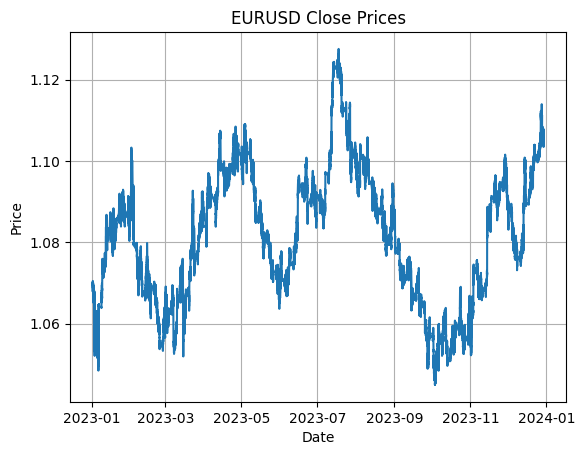

In [ ]:
import matplotlib.pyplot as plt

# Plot the EURUSD Close prices
plt.plot(EURUSD.index, EURUSD['Close'])

# Customize the plot
plt.title('EURUSD Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Show the plot
plt.show()

## Plot in finer detail just one month
2023-5

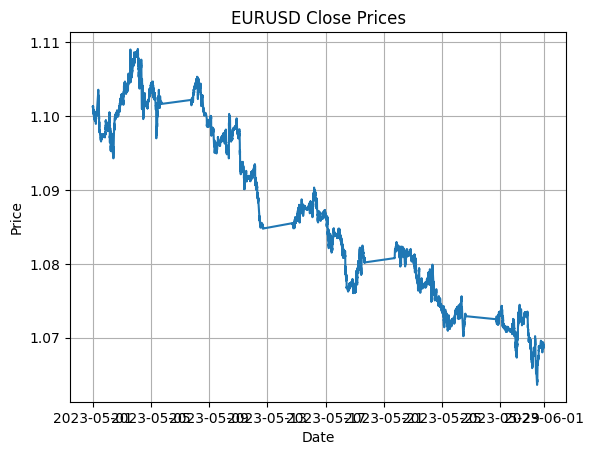

In [ ]:
# Plot the EURUSD Close prices
may_2023 = EURUSD[(EURUSD.index.year == 2023) & (EURUSD.index.month == 5)]
plt.plot(may_2023.index, may_2023['Close'])

# Customize the plot
plt.title('EURUSD Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Show the plot
plt.show()

# Data Munging
* are there lots of nans?
* Should we review them?
* does it make sense to consider a day of the week effect?


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Check for weekend data in EURUSD
weekend_data_EURUSD = EURUSD[(EURUSD.index.dayofweek == 5) | (EURUSD.index.dayofweek == 6)]
all_nans = EURUSD['Close'].isna().sum() / EURUSD.shape[0]
weekend_nans = weekend_data_EURUSD['Close'].isna().sum()/weekend_data_EURUSD.shape[0]

print(f"all nans: {all_nans} ")
print(f"weekend NaNs: {weekend_nans}" )

#print(" Weekend NaNs :" + weekend_data_EURUSD['close'].isna().sum()/weekend_data_EURUSD.shape[0])
# print("EURUSD Weekend data:")
# print(weekend_data_EURUSD)  # Print weekend data to confirm if it's empty

# Add day-of-the-week indicators to EURUSD (if needed)
EURUSD['day_of_week'] = EURUSD.index.dayofweek  # Monday=0, Sunday=6
EURUSD = pd.get_dummies(EURUSD, columns=['day_of_week'], prefix='dow', drop_first=True)
# Create dummy variables for Tuesday to Friday (Monday is the baseline)

# ... (add any further analysis or plotting you need here)

# Plot EURUSD for May 2023 (if needed)


# Example usage:
# analyze_EURUSD_data(EURUSD)


all nans: 0.0 
weekend NaNs: 0.0


## Whats's going on?
At this stage I would just
dataframe.to_csv('csvfile.csv') and look at the data in excel. (why not?)

## Start Creating Features


# Feature and Feature Manager
Two classes, one an ABC which templates all feature classes. We start out with two but will consider others like

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd

class Feature(ABC):
    """
    Abstract base class for features.
    """

    def __init__(self, name: str):
        self.name = name

    @abstractmethod
    def calculate(self, data: pd.DataFrame) -> pd.Series:
        """
        Calculates the feature values.

        Args:
            data: The input data DataFrame.

        Returns:
            A pandas Series containing the feature values.
        """
        pass


class MeanReversionFeature(Feature):
    """
    Mean reversion feature based on MACD.
    """

    def __init__(self, name: str, short_span: int, long_span: int):
        super().__init__(name)
        self.short_span = short_span
        self.long_span = long_span

    def calculate(self, data: pd.DataFrame) -> pd.Series:
        """
        Calculates the mean reversion feature.

        Args:
            data: The input data DataFrame with a "Close" column.

        Returns:
            A pandas Series containing the feature values.
        """
        close_prices = data["Close"]  # Assuming data has a "Close" column
        return close_prices.ewm(span=self.short_span).mean() - close_prices.ewm(span=self.long_span).mean()


class FeatureManager:
    """
    Manages a collection of features.
    """

    def __init__(self):
        self.features = []

    def add_feature(self, feature: Feature):
        """
        Adds a feature to the manager.

        Args:
            feature: The feature to add.
        """
        self.features.append(feature)

    def calculate_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates all features for the given data.

        Args:
            data: The input data DataFrame.

        Returns:
            A DataFrame with the calculated features.
        """
        feature_values = {}
        for feature in self.features:
            feature_values[feature.name] = feature.calculate(data)
        return pd.DataFrame(feature_values, index=data.index)

In [ ]:
# Create a FeatureManager
feature_manager = FeatureManager()

# Create mean reversion features
mean_reversion_short = MeanReversionFeature("MeanReversion_Short", 3, 15)  # 3-15 min MACD
mean_reversion_medium = MeanReversionFeature("MeanReversion_Medium", 5, 25)  #
mean_reversion_medium2 = MeanReversionFeature("MeanReversion_Medium2", 1440, 7200) #1 day/5day
mean_reversion_long = MeanReversionFeature("MeanReversion_Long", 1440, 43200)  # 24-hour vs 30-day MACD (assuming 1-min data)

# Add features to the manager
feature_manager.add_feature(mean_reversion_short)
feature_manager.add_feature(mean_reversion_long)

# Calculate features for your data (assuming your DataFrame is called EURUSD)
features_df = feature_manager.calculate_features(EURUSD)

# Display the calculated features
print(features_df.head())

                     MeanReversion_Short  MeanReversion_Long
DateTime                                                    
2023-01-01 17:04:00             0.000000        0.000000e+00
2023-01-01 17:05:00             0.000001        3.356481e-09
2023-01-01 17:06:00            -0.000008       -1.790765e-08
2023-01-01 17:08:00             0.000008        1.176455e-08
2023-01-01 17:10:00             0.000008        1.880977e-08


In [ ]:
import pandas as pd

class PinbarFeature(Feature):
    """
    Feature to detect pinbars.
    """

    def __init__(self, name: str, body_threshold: float = 0.2, wick_threshold: float = 0.7):
        super().__init__(name)
        self.body_threshold = body_threshold  # Threshold for the body size relative to the range
        self.wick_threshold = wick_threshold  # Threshold for the wick size relative to the range

    def calculate(self, data: pd.DataFrame) -> pd.Series:
        """
        Calculates the pinbar feature.

        Args:
            data: The input data DataFrame with columns "Open", "High", "Low", "Close".

        Returns:
            A pandas Series containing +1 for bullish pinbars, -1 for bearish pinbars,
            and 0 otherwise.
        """

        # Calculate the range and body size
        data["Range"] = data["High"] - data["Low"]
        data["Body"] = abs(data["Close"] - data["Open"])

        # Calculate the upper and lower shadows (wicks)
        data["UpperShadow"] = data["High"] - data[["Close", "Open"]].max(axis=1)
        data["LowerShadow"] = data[["Close", "Open"]].min(axis=1) - data["Low"]

        # Identify pinbars based on thresholds
        is_pinbar = (
            (data["Body"] / data["Range"] <= self.body_threshold)
            & (
                (data["UpperShadow"] / data["Range"] >= self.wick_threshold)
                | (data["LowerShadow"] / data["Range"] >= self.wick_threshold)
            )
        )


        # ... (previous code for range, body, shadows remains the same) ...

        # Identify bullish and bearish pinbars
        is_bullish_pinbar = (
            (data["Body"] / data["Range"] <= self.body_threshold)
            & (data["LowerShadow"] / data["Range"] >= self.wick_threshold)
            & (data["Close"] > data["Open"])  # Close is higher than Open (bullish)
        )

        is_bearish_pinbar = (
            (data["Body"] / data["Range"] <= self.body_threshold)
            & (data["UpperShadow"] / data["Range"] >= self.wick_threshold)
            & (data["Close"] < data["Open"])  # Close is lower than Open (bearish)
        )

        # Combine the results
        pinbar_direction = pd.Series(0, index=data.index)  # Initialize with 0
        pinbar_direction[is_bullish_pinbar] = 1
        pinbar_direction[is_bearish_pinbar] = -1



        return pinbar_direction  # Convert to 1 for pinbars, 0 otherwise

In [ ]:
# Create a PinbarFeature
pinbar_feature = PinbarFeature("Pinbar", body_threshold=0.2, wick_threshold=0.7)

# Add the feature to the FeatureManager
feature_manager.add_feature(pinbar_feature)



# ... (create FeatureManager, PinbarFeature, add to FeatureManager) ...

features_df = feature_manager.calculate_features(EURUSD)

# Now the 'Pinbar' column will have +1, -1, or 0
print(features_df.head())


                     MeanReversion_Short  MeanReversion_Long  Pinbar
DateTime                                                            
2023-01-01 17:04:00             0.000000        0.000000e+00       0
2023-01-01 17:05:00             0.000001        3.356481e-09       0
2023-01-01 17:06:00            -0.000008       -1.790765e-08       0
2023-01-01 17:08:00             0.000008        1.176455e-08       0
2023-01-01 17:10:00             0.000008        1.880977e-08       0


,0
MeanReversion_Short,0.999997
MeanReversion_Long,0.999997
Pinbar,0.022868


In [ ]:
import pandas as pd
import numpy as np

class GarmanKlassFeature(Feature):
    """
    Feature to calculate Garman-Klass volatility.
    """

    def __init__(self, name: str):
        super().__init__(name)

    def calculate(self, data: pd.DataFrame) -> pd.Series:
        """
        Calculates the Garman-Klass volatility.

        Args:
            data: The input data DataFrame with columns "Open", "High", "Low", "Close".

        Returns:
            A pandas Series containing the Garman-Klass volatility values.
        """

        return np.sqrt(
            0.5 * (np.log(data["High"] / data["Low"]) ** 2)
            - (2 * np.log(2) - 1) * (np.log(data["Close"] / data["Open"]) ** 2)
        )


class ForwardReturnsFeature(Feature):
    """
    Feature to calculate forward returns.
    """

    def __init__(self, name: str):
        super().__init__(name)

    def calculate(self, data: pd.DataFrame) -> pd.Series:
        """
        Calculates the forward returns.

        Args:
            data: The input data DataFrame with a "Close" column.

        Returns:
            A pandas Series containing the forward returns.
        """

        return data["Close"].diff().shift(-1)

In [ ]:
# Create the features
garman_klass_feature = GarmanKlassFeature("GK_Volatility")
forward_returns_feature = ForwardReturnsFeature("fwd_rets")

# Add the features to the FeatureManager
feature_manager.add_feature(garman_klass_feature)
feature_manager.add_feature(forward_returns_feature)

# Calculate features (including GK Volatility and forward returns)
features_df = feature_manager.calculate_features(EURUSD)

# Display the updated features DataFrame
print(features_df.head())

                     MeanReversion_Short  MeanReversion_Long  Pinbar  \
DateTime                                                               
2023-01-01 17:04:00             0.000000        0.000000e+00       0   
2023-01-01 17:05:00             0.000001        3.356481e-09       0   
2023-01-01 17:06:00            -0.000008       -1.790765e-08       0   
2023-01-01 17:08:00             0.000008        1.176455e-08       0   
2023-01-01 17:10:00             0.000008        1.880977e-08       0   

                     GK_Volatility  fwd_rets  
DateTime                                      
2023-01-01 17:04:00       0.000026   0.00001  
2023-01-01 17:05:00       0.000052  -0.00005  
2023-01-01 17:06:00       0.000000   0.00008  
2023-01-01 17:08:00       0.000013  -0.00002  
2023-01-01 17:10:00       0.000050   0.00000  


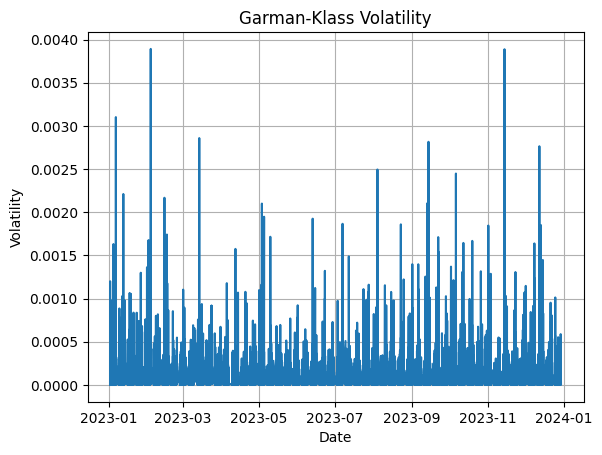

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'GK_Volatility' is the column name in features_df
plt.plot(features_df.index, features_df['GK_Volatility'])

# Customize the plot
plt.title('Garman-Klass Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import pandas as pd

# Assuming your features DataFrame is named features_df
# and it has a DateTimeIndex

monthly_correlations = []

for month in range(1, 9):  # Iterate through months 1 to 8
    # Filter data for the current month
    monthly_data = features_df[
        (features_df.index.year == 2023) & (features_df.index.month == month)
    ]

    # Calculate correlations
    correlations = monthly_data.corr()["fwd_rets"].drop("fwd_rets")  # Exclude self-correlation

    # Store results with month information
    monthly_correlations.append(correlations.to_frame(name=month))

# Concatenate monthly results into a single DataFrame
correlation_df = pd.concat(monthly_correlations, axis=1)

# Display the DataFrame
correlation_df

,1,2,3,4,5,6,7,8
MeanReversion_Short,-0.040949,-0.009322,-0.011770,-0.013763,-0.026900,-0.004497,0.008669,-0.007039
MeanReversion_Long,-0.004487,-0.008398,-0.010300,-0.024438,-0.000921,-0.009785,-0.004615,-0.010136
Pinbar,-0.013464,-0.007829,0.001635,-0.014324,-0.006734,0.003237,-0.008280,-0.002947
GK_Volatility,-0.002760,0.008183,-0.003562,0.014672,0.004085,0.001588,-0.002143,0.001374


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# ... (rest of the rolling_regression_forecast function remains the same)

def rolling_regression_forecast(
    features_df: pd.DataFrame, window_size: int = 7 * 1440  # 1 week in minutes
) -> pd.DataFrame:
    # ... (existing code)

    # Plot PnL
    # ... (existing code)

    # Plot EURUSD for May 2023
    EURUSD_may_2023 = EURUSD[(EURUSD.index.year == 2023) & (EURUSD.index.month == 5)]
    plt.figure(figsize=(12, 6))
    plt.plot(EURUSD_may_2023)
    plt.title("EURUSD - May 2023")
    plt.xlabel("Date")
    plt.ylabel("EURUSD Price")
    plt.grid(True)
    plt.show()

    # ... (rest of the function remains the same)

In [ ]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# def rolling_regression_forecast(
#     features_df: pd.DataFrame, window_size: int = 7 * 1440  # 1 week in minutes
# ) -> pd.DataFrame:
#     """
#     Performs rolling regression to forecast forward returns.

#     Args:
#         features_df: DataFrame with features and 'fwd_rets'.
#         window_size: Size of the rolling window in minutes (default: 1 week).

#     Returns:
#         DataFrame with forecasts and performance metrics.
#     """

#     # Assuming your DataFrame is called features_df
#     # and it has a DateTimeIndex
#     # It should contain 'fwd_rets' and other feature columns

#     # Ensure index is unique before proceeding
#     features_df = features_df[~features_df.index.duplicated(keep='first')]

#     results_df = pd.DataFrame(index=features_df.index)
#     results_df["y_true"] = features_df["fwd_rets"]  # Store true values
#     results_df["y_pred"] = np.nan  # Initialize predictions with NaN

#     start_index = 0
#     while start_index + window_size < len(features_df):
#         # Get data for the current window
#         window_data = features_df.iloc[start_index : start_index + window_size]

#         # Separate features (X) and target (y)
#         X = window_data.drop(columns=["fwd_rets"])
#         y = window_data["fwd_rets"]

#         # Fit the regression model
#         X = sm.add_constant(X)  # Add a constant term
#         model = sm.OLS(y, X).fit()

#         # Forecast for the next week
#         next_week_data = features_df.iloc[
#             start_index + window_size : start_index + 2 * window_size
#         ]
#         next_week_X = sm.add_constant(X)  # Add a constant term

#         # using .values will avoid reindexing
#         results_df.loc[
#             next_week_data.index, "y_pred"
#         ] = model.predict(next_week_X).values  # Store predictions

#         start_index += window_size  # Move to the next window

#     # Calculate performance metrics
#     results_df = results_df.dropna()  # Remove rows with NaN predictions
#     mse = mean_squared_error(results_df["y_true"], results_df["y_pred"])
#     mape = mean_absolute_percentage_error(results_df["y_true"], results_df["y_pred"])
#     correlation = results_df["y_true"].corr(results_df["y_pred"])

#     print(f"Out-of-sample MSE: {mse}")
#     print(f"Out-of-sample MAPE: {mape}")
#     print(f"Correlation between y and y^: {correlation}")

#     return results_df

In [ ]:
results_df = rolling_regression_forecast(features_df)

# results_df now contains 'y_true', 'y_pred', and performance metrics

Out-of-sample MSE: 2.130758175063508e-08
Out-of-sample MAPE: 2606963755.121264
Correlation between y and y^: 0.0030065078666090296


* Rule of thumb SR with no tcosts
$$ SR = \frac{\rho}{(\rho^2+1)^{1/2}} $$
* In this case, 0.003, leads to a SR of 2.17. (not great given the frequency of trading but we'll go with it).






In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def rolling_regression_forecast(
    features_df: pd.DataFrame, window_size: int = 7 * 1440  # 1 week in minutes
) -> pd.DataFrame:
    """
    Performs rolling regression to forecast forward returns.

    Args:
        features_df: DataFrame with features and 'fwd_rets'.
        window_size: Size of the rolling window in minutes (default: 1 week).

    Returns:
        DataFrame with forecasts and performance metrics.
    """

    # Assuming your DataFrame is called features_df
    # and it has a DateTimeIndex
    # It should contain 'fwd_rets' and other feature columns

    # Ensure index is unique before proceeding
    # If there are duplicates, keep the first occurrence
    features_df = features_df[~features_df.index.duplicated(keep='first')]

    results_df = pd.DataFrame(index=features_df.index)
    results_df["y_true"] = features_df["fwd_rets"]  # Store true values
    results_df["y_pred"] = np.nan  # Initialize predictions with NaN

    start_index = 0
    while start_index + window_size < len(features_df):
        # Get data for the current window
        window_data = features_df.iloc[start_index : start_index + window_size]

        # Separate features (X) and target (y)
        X = window_data.drop(columns=["fwd_rets"])
        y = window_data["fwd_rets"]

        # Fit the regression model
        X = sm.add_constant(X)  # Add a constant term
        model = sm.OLS(y, X).fit()

        # Forecast for the next week
        next_week_data = features_df.iloc[
            start_index + window_size : start_index + 2 * window_size
        ]

        # Ensure next_week_data also has a unique index
        next_week_data = next_week_data[~next_week_data.index.duplicated(keep='first')]

        next_week_X = sm.add_constant(next_week_data.drop(columns=["fwd_rets"]))  # Add a constant term and drop target for prediction

        # using .values and aligning indices will avoid reindexing issues
        # Get the common index between next_week_data and results_df
        common_index = next_week_data.index.intersection(results_df.index)

        # Assign predictions to the common index in results_df
        results_df.loc[common_index, "y_pred"] = model.predict(next_week_X).values  # Store predictions

        start_index += window_size  # Move to the next window

    # Calculate performance metrics
    results_df = results_df.dropna()  # Remove rows with NaN predictions
    mse = mean_squared_error(results_df["y_true"], results_df["y_pred"])
    mape = mean_absolute_percentage_error(results_df["y_true"], results_df["y_pred"])
    correlation = results_df["y_true"].corr(results_df["y_pred"])

    print(f"Out-of-sample MSE: {mse}")
    print(f"Out-of-sample MAPE: {mape}")
    print(f"Correlation between y and y^: {correlation}")

In [ ]:
results_df = rolling_regression_forecast(features_df)

Out-of-sample MSE: 2.130758175063508e-08
Out-of-sample MAPE: 2606963755.121264
Correlation between y and y^: 0.0030065078666090296


In [ ]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# def rolling_regression_forecast(
#     features_df: pd.DataFrame, window_size: int = 7 * 1440  # 1 week in minutes
# ) -> pd.DataFrame:
#     """
#     Performs rolling regression to forecast forward returns.

#     Args:
#         features_df: DataFrame with features and 'fwd_rets'.
#         window_size: Size of the rolling window in minutes (default: 1 week).

#     Returns:
#         DataFrame with forecasts and performance metrics.
#     """

#     # Assuming your DataFrame is called features_df
#     # and it has a DateTimeIndex
#     # It should contain 'fwd_rets' and other feature columns

#     results_df = pd.DataFrame(index=features_df.index)
#     results_df["y_true"] = features_df["fwd_rets"]  # Store true values
#     results_df["y_pred"] = np.nan  # Initialize predictions with NaN

#     start_index = 0
#     while start_index + window_size < len(features_df):
#         # Get data for the current window
#         window_data = features_df.iloc[start_index : start_index + window_size]

#         # Separate features (X) and target (y)
#         X = window_data.drop(columns=["fwd_rets"])
#         y = window_data["fwd_rets"]

#         # Fit the regression model
#         X = sm.add_constant(X)  # Add a constant term
#         model = sm.OLS(y, X).fit()

#         # Forecast for the next week
#         next_week_data = features_df.iloc[
#             start_index + window_size : start_index + 2 * window_size
#         ]
#         next_week_X = sm.add_constant(X)  # Add a constant term
#         results_df.loc[
#             next_week_data.index, "y_pred"
#         ] = model.predict(next_week_X)  # Store predictions

#         start_index += window_size  # Move to the next window

#     # Calculate performance metrics
#     results_df = results_df.dropna()  # Remove rows with NaN predictions
#     mse = mean_squared_error(results_df["y_true"], results_df["y_pred"])
#     mape = mean_absolute_percentage_error(results_df["y_true"], results_df["y_pred"])
#     correlation = results_df["y_true"].corr(results_df["y_pred"])

#     print(f"Out-of-sample MSE: {mse}")
#     print(f"Out-of-sample MAPE: {mape}")
#     print(f"Correlation between y and y^: {correlation}")

#     return results_df
